# Analysis on E. coli strians

In [2]:
import cobra
import pandas as pd
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os 
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
## import the dataframe at species level
df_species=pd.read_csv('./data/metaphlan2_species_level_abundance_classified.csv',index_col=0)
df_ecoli=pd.DataFrame(data=df_species.T['k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli']) 

#check E.coli abundance  
print 'number of total samples: ', len(df_ecoli)
print 'number of samples with e.coli greater than 5%: ', sum(i > 1 for i in df_ecoli.values)

## load metadata 
df_meta=pd.read_csv('./data/metadata_updated_filtered_201904.csv',index_col=0)
dic_surgery=dict(zip(df_meta.index,df_meta.surgery_type))
dic_surgeryByHost=dict(zip(df_meta.host_id,df_meta.surgery_type))
dic_host=dict(zip(df_meta.index,df_meta.host_id))
dic_time=dict(zip(df_meta.index,df_meta.time_point_month))

number of total samples:  301
number of samples with e.coli greater than 5%:  [146]


### Compare the E. coli abundance across subgroups 

In [8]:
# add a column to label the surgery subtype

# flatten the dataframe for plotting purpose
surgery_label=[]
for i in df_ecoli.index: 
    if dic_surgery[i]=='none': 
        surgery_label.append('No surgery')
    elif dic_surgery[i]=='colectomy': 
        surgery_label.append('Colectomy')
    else: 
        surgery_label.append('Ileocolonic')
df_ecoli['surgery']=surgery_label
df_ecoli=df_ecoli.reset_index()

Text(0,0.5,'Relative abundance of E.coli (%)')

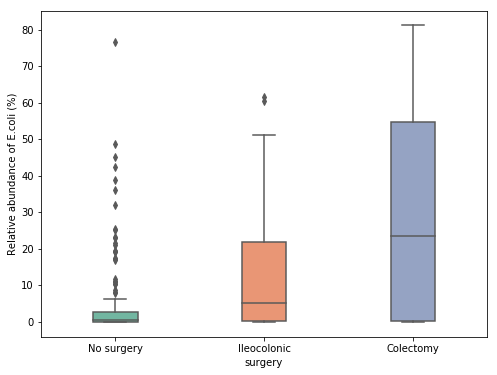

In [9]:
import seaborn as sns 

## add the surgery label to the flattened dataframe 
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.boxplot(y="k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia|s__Escherichia_coli", x="surgery",data=df_ecoli,palette=['#66c2a5','#fc8d62','#8da0cb'],
                 width=0.3,order=["No surgery", "Ileocolonic", "Colectomy"])
plt.ylabel('Relative abundance of E.coli (%)')
#fig.savefig('../data/Sandborn_data/figures/E.coli abundance in subgroups.svg')
#fig.savefig('../data/Sandborn_data/figures/E.coli abundance in subgroups.pdf')

## Investigate dynamics of dominant strain  using SNP profiles generated by MIDAS

SNP profiles for E.coli were generated for 178 samples with using MIDAS with the following command with default settings: 

run_midas.py snps output_folder --species_id Escherichia_coli_58110 -t 24 -1 sample.R1.fastq.gz -2 sample.R2.fastq.gz 



In [11]:
#load dataframe SNP 

df_snp=pd.read_csv('./data/snps_freq.txt',sep='\t',index_col=0)
print df_snp.shape
df_snp=df_snp.drop('PLCL22251',1)

df_snp.head()

(24641, 179)


,PLCL18250,PLCL22166,PLCL23147,PLCL20066,PLCL20088,PLCL24015,PLCL18755,PLCL17842,PLCL23175,PLCL20124,...,PLCL19273,PLCL20974,PLCL21475,PLCL25745_1,PLCL21491,PLCL17719,PLCL18909,PLCL18260,PLCL22156,PLCL19578
site_id,,,,,,,,,,,,,,,,,,,,,
352,0.0000,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.00000,0.00000,0.000,0.0,0.0,0.0,0.0,0.001650,0.00000,0.0000
516,0.0000,0.0,0.000,0.0,0.0,1.0,0.0,0.870,1.0,0.000,...,1.00000,0.00000,0.549,0.0,0.0,1.0,1.0,0.000329,0.00889,0.0556
1082,0.0000,0.0,0.545,0.0,0.0,0.0,0.0,0.615,1.0,0.333,...,1.00000,0.00000,0.924,0.0,0.0,1.0,1.0,0.000000,0.00000,0.1110
1102,0.0000,0.0,0.000,0.0,0.0,1.0,0.0,0.636,0.0,0.000,...,0.99900,0.00000,0.000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0500
1103,0.0244,0.0,0.333,0.0,0.0,1.0,0.0,0.000,1.0,0.333,...,0.00112,0.00501,0.924,0.0,0.0,1.0,1.0,0.008720,0.00000,0.0909


In [12]:
## filter for host that has more than 1 E.coli samples for plot 
dic_count={}
for s in df_snp.columns: 
    host=dic_host[s]
    if not host in dic_count: 
        dic_count[host]=1
    else: 
        dic_count[host]=dic_count[host]+1

host_longi=[k for k in dic_count.keys() if dic_count[k]>1]
sample_longi=[s for s in df_snp.columns if dic_host[s] in host_longi]
df_pan_longi=df_snp[sample_longi]
df_pan_longi.shape

#remove genes that are not present in any sandborn strains 
gene_present=[g for g in df_pan_longi.index if sum(df_pan_longi.loc[g]>0)]
df_pan_longi=df_pan_longi.loc[gene_present]

In [13]:
#create a dataframe to store the host/time for each samples 
hostlist=[]
timelist=[]
for s in sample_longi: 
    hostlist.append(dic_host[s])
    timelist.append(dic_time[s])
df_info=pd.DataFrame(index=sample_longi)
df_info['host']=hostlist
df_info['time']=timelist
df_info=df_info.sort_values(by=['host','time'])
df_info

,host,time
PLCL17524,100001,0
PLCL19615,100001,6
PLCL17532,100005,0
PLCL19620,100005,6
PLCL18281,100008,6
PLCL21475,100008,12
PLCL22332,100008,18
PLCL17725,100009,0
PLCL17528,100009,6
PLCL21395,100009,12


In [8]:
#calculate the distance for each neighboring dominant strain based on snp profiles
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

dic_distance={}
for h in host_longi: 
    df_temp=df_info[df_info.host==h]
    for i in range(len(df_temp)-1): 
        s1=df_temp.iloc[i].name
        s2=df_temp.iloc[i+1].name
        dist=pdist(df_pan_longi[[s1,s2]],metric='mahalanobis')
        if not h in dic_distance.keys(): 
            dic_distance[h]=[dist[0]]
        else: 
            dic_distance[h].append(dist[0])
# select a value to fill in the non-existing samples to allow plotting later     
    while len(dic_distance[h])<3: 
        dic_distance[h].append(4)

In [9]:
df_disctance=pd.DataFrame.from_dict(dic_distance).T
df_disctance=df_disctance.replace(to_replace=-1,value=4)

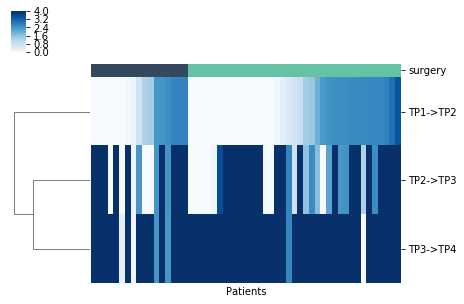

In [22]:
#create label for surgery for hosts 
patient_col=[]
for i in df_disctance.index: 
    if dic_surgeryByHost[i]=='none': 
        patient_col.append('#66c2a5')
    else: 
        patient_col.append('#34495e')

df_disctance['surgery']=patient_col

#add surgery status to the plot 
df_disctance=df_disctance.sort_values(by=['surgery',0,1,2])
g=sns.clustermap(df_disctance[[0,1,2]].T,cmap='Blues',figsize=(7,5),col_colors=df_disctance['surgery'],col_cluster=False,mask=0)
ax = g.ax_heatmap
ax.set_yticklabels(['TP1->TP2','TP2->TP3','TP3->TP4'],rotation=0)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_xlabel('Patients')
#g.savefig('../data/Sandborn_data/figures/Dominant Ecoli strain Change similarity.svg')
#g.savefig('../data/Sandborn_data/figures/Dominant Ecoli strain Change similarity.pdf')

## Analyze Panphlan results
Gene presence/absence matrix of E.coli is generated for 147 samples with E.coli abundance greater than 1% using Panphlan. Panphlan was run with default settings and the database used was "ecoli16" downloaded provided on the Panphlan website

In [14]:
##load panphlan results 

df_panphlan=pd.read_csv('./data/gene_presence_ecoli16.csv',index_col=0,sep='\t')

#only keep the samples from sandborn data 
sandborn_sample=[i for i in df_panphlan.columns if 'PLCL' in i]
df_panphlan=df_panphlan[sandborn_sample]
df_panphlan=df_panphlan.drop('PLCL22251',1)
print df_panphlan.shape


(31734, 147)


### Analysis on metabolic functions
Draft metabolic genome scale models were created based on genome content identified by panphlan for each sample.
Then the pan reactome matrix is created that specifies the presence/absence of each metabolic reaction in the sample-specific draft models. Here we analyze the pre-computed pan-reactome matrix

In [15]:
#only look at sandborn samples 
df_rxn=pd.read_csv('./data/pan_reactome_matrix.csv',index_col=0)
df_rxn_samples=df_rxn[sandborn_sample]
df_rxn_samples=df_rxn_samples.drop('PLCL22251',1)
df_rxn_samples.shape


(3077, 147)

### Analysis on AIEC associated virulence factors
We mapped the Panphlan derived assemblies against a reference databse with AIEC associated VFs using BLAST. Here we look at the output results that specified the sequence similarity of each VF in all assemblies

In [16]:
## load mapping results from VF genes 
df_AIEC_map=pd.read_csv('./data/AIEC_VF_comparative.csv',index_col=0)
df_AIEC_map=df_AIEC_map.fillna(value=0)
df_AIEC_map.shape
df_AIEC_sample=df_AIEC_map[df_rxn_samples.columns]
df_AIEC_sample.shape

#concat AIEC+ mtabolism

df_VF_metab=pd.concat([df_AIEC_sample,df_rxn_samples])
print df_VF_metab.shape

(3102, 147)


In [17]:
import mca
#create MCA instance 
X=df_VF_metab.T
mca_ben = mca.MCA(X,TOL=1e-9)
mca_ind = mca.MCA(X, benzecri=False,TOL=1e-9)
fs=np.asarray(mca_ben.fs_r(N=4))
mca_ben.expl_var(greenacre=True, N=4)

array([0.73497173, 0.11436956, 0.04364698, 0.03042905])

### MCA plot on VF and metabolic reaction matrix

In [18]:
#label the plot 

color_surgery=[]
for i in df_VF_metab.columns: 
    if dic_surgery[i]=='none': 
        color_surgery.append('#66c2a5')
    else: 
        color_surgery.append('#34495e')


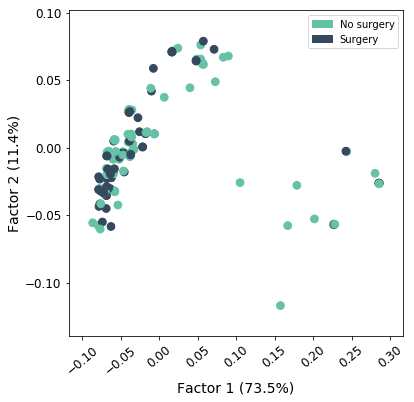

In [19]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)
n=list(df_VF_metab.columns)
plot=ax.scatter(fs[:,0],fs[:,1],s=60, c=color_surgery)
plt.xlabel('Factor 1 (73.5%)',fontsize=14)
plt.ylabel('Factor 2 (11.4%)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(rotation=40)
plt.grid(False)
blue = mpatches.Patch(color='#66c2a5', label='No surgery')
brown = mpatches.Patch(color='#34495e', label='Surgery')
plt.legend(handles=[blue,brown])
#fig.savefig('../data/Sandborn_data/figures/Metabolis and VF dominant ecoli strians.svg')
#fig.savefig('../data/Sandborn_data/figures/Metabolis and VF dominant ecoli strians.pdf')